<img src = "https://github.com/VeryFatBoy/notebooks/blob/main/common/images/img_github_singlestore-jupyter_featured_2.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Using SingleStore as a Geospatial Database</h1>
    </div>
</div>

In [4]:
!pip cache purge --quiet

In [5]:
!pip install geopandas --quiet
!pip install matplotlib --quiet

In [6]:
import pandas as pd
import geopandas as gpd
import warnings

from shapely import wkt

warnings.filterwarnings("ignore")

In [7]:
boroughs_csv_url = "https://raw.githubusercontent.com/VeryFatBoy/singlestore-geospatial-example/refs/heads/main/datasets/London_Borough_Excluding_MHW.csv"

boroughs_df = pd.read_csv(boroughs_csv_url)

In [8]:
boroughs_df["geometry"] = boroughs_df["WKT"].apply(wkt.loads)
boroughs_df.rename(columns = {"NAME": "name", "HECTARES": "hectares"}, inplace = True)
boroughs_df.drop(
    columns = ["WKT", "GSS_CODE", "NONLD_AREA", "ONS_INNER", "SUB_2009", "SUB_2006"],
    inplace = True
)

In [9]:
# Create GeoDataFrame, explode geometry, and set CRS
boroughs_geo_df = gpd.GeoDataFrame(boroughs_df, geometry = "geometry")
boroughs_geo_df = boroughs_geo_df.explode(column = "geometry", index_parts = False)
boroughs_geo_df = boroughs_geo_df.set_crs("EPSG:4326", allow_override = True)

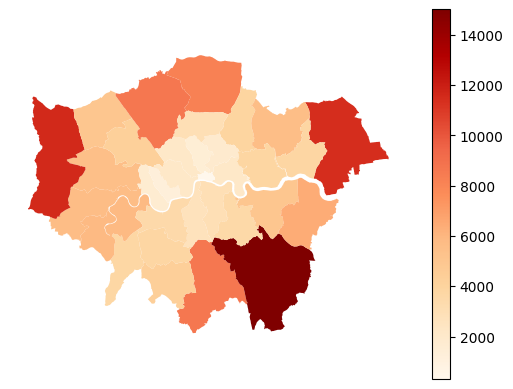

In [10]:
# Plot the map
map = boroughs_geo_df.plot(column = "hectares", cmap = "OrRd", legend = True)
map.set_axis_off()

"Contains National Statistics data © Crown copyright and database right [2015]" and "Contains Ordnance Survey data © Crown copyright and database right [2015]"

In [11]:
# Calculate centroids
boroughs_geo_df = boroughs_geo_df.assign(centroid = boroughs_geo_df["geometry"].centroid)

In [12]:
# Keep the original geometries and centroids but also add WKT versions
boroughs_geo_df["geometry_wkt"] = boroughs_geo_df["geometry"].apply(wkt.dumps)
boroughs_geo_df["centroid_wkt"] = boroughs_geo_df["centroid"].apply(wkt.dumps)

In [13]:
# Drop geometries and centroids
boroughs_geo_df.drop(columns = ["geometry", "centroid"], inplace = True)
boroughs_geo_df.rename(columns = {"geometry_wkt": "geometry", "centroid_wkt": "centroid"}, inplace = True)

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [16]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

In [17]:
boroughs_geo_df.to_sql(
    "london_boroughs",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

36